In [1]:
from src.pispec import PiSpec
from src.trace_utils import TraceParams
import matplotlib.pyplot as plt

In [2]:
# initialize the interface
pispec = PiSpec()

# alternate the datapoints between two detectors? 
# Thats a tracecontroller things

5824


In [3]:
# define some trace parameters
params1 = TraceParams(num_points=2500,
    pulse_interval = 1000,
    meas_led_ir = 0,
    meas_led_vis = 1,
    pulse_length = 75,
    sat_pulse_begin = 500,
    sat_pulse_end = 600,
    pulse_mode = 1,
    trigger_delay = 0,
    trace_note = "debug",
    act_intensity = [0, 0, 0]
)

In [4]:
#experiment variables
exp_name = "testBadger"
trace_params = [params1]

# begin experiment
pow_cmd, pow_state = pispec.power(1)
print(f'Power set to {pow_cmd}, response is {pow_state}')

pispec.init_experiment(exp_name=exp_name)

for param in trace_params:
    
    # setup the trace paramaters
    pispec.setup_trace(params1)

    # see if the trace parameters are in place
    print(f"The current trace parameters are: {pispec.tracecontroller.get_parameters()}")

    # run trace
    status = pispec.run_trace(timeout=100000)
    print(f"pispec.run_trace completed with status: {status}")

    # wait between traces
    # pispec.wait(5)

pow_cmd, pow_state = pispec.power(1)
print(f'Power set to {pow_cmd}, response is {pow_state}')

print(f"Experiment '{exp_name}' concluded, trace data is ready for processing.")

Power set to 1, response is 1

The current trace parameters are: counter=2501, sat_pulse_begin=500, sat_pulse_end=600, pulse_length=75, pulse_interval=1000, meas_led_vis=2, meas_led_ir=0, num_points=2500, pulse_mode=1, act_int_phase=[0,0,0];

pispec.run_trace completed with status: 0
Power set to 1, response is 1

Experiment 'testBadger' concluded, trace data is ready for processing.


In [5]:
# dfs = pispec.get_data()
dfs = pispec.get_data()
df = dfs[0]


In [6]:
print(df.head())


   trace_num  rep   trace_begun     trace_end  \
0          0    0  1.663632e+09  1.663632e+09   
1          0    0  1.663632e+09  1.663632e+09   
2          0    0  1.663632e+09  1.663632e+09   
3          0    0  1.663632e+09  1.663632e+09   
4          0    0  1.663632e+09  1.663632e+09   

                            param_string note  pt_num  time_us     aq_0  \
0  r0;v1;n2500;z1;i1000;p75;e0;w0;x0;y0;          0.0     14.0  36096.0   
1  r0;v1;n2500;z1;i1000;p75;e0;w0;x0;y0;          1.0   1015.0  36096.0   
2  r0;v1;n2500;z1;i1000;p75;e0;w0;x0;y0;          2.0   2016.0  36096.0   
3  r0;v1;n2500;z1;i1000;p75;e0;w0;x0;y0;          3.0   3017.0  35840.0   
4  r0;v1;n2500;z1;i1000;p75;e0;w0;x0;y0;          4.0   4018.0  35840.0   

      aq_1     aq_2     aq_3     aq_4  
0  36096.0  35840.0  35840.0  36096.0  
1  36096.0  36096.0  35840.0  35840.0  
2  36096.0  36096.0  36096.0  36096.0  
3  36096.0  36096.0  36096.0  36096.0  
4  35840.0  36096.0  36096.0  36096.0  


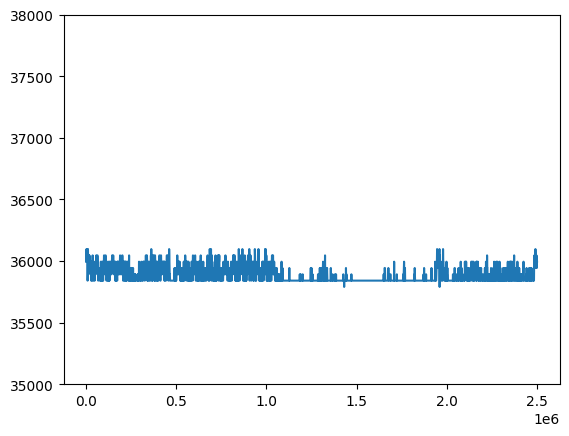

In [24]:
# row means of all the data points
df["val"] = df[['aq_0', 'aq_1', 'aq_2', 'aq_3', 'aq_4']].mean(numeric_only = True, axis=1)

df["V"] = df["val"] / 6535

plt.plot(df['time_us'], df['val'])
plt.ylim(35000, 38000)
plt.show()

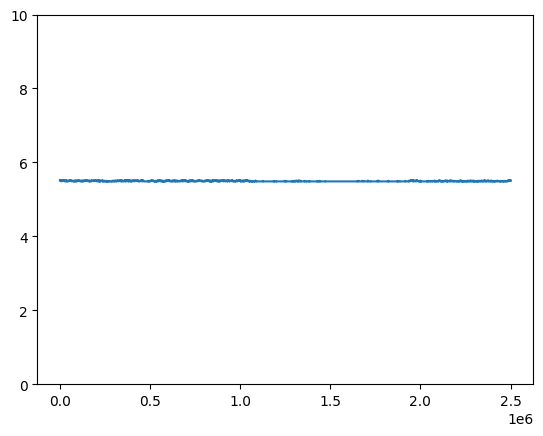

In [19]:
plt.plot(df['time_us'], df['V'])
plt.ylim(0, 10)
plt.show()

In [10]:
(x='time_us', y='val')
plt.show()

# plt.plot(df['time_us'], df['aq_0'])
# plt.show()

SyntaxError: invalid syntax (1491350277.py, line 1)

In [ ]:

# pispec.tracecontroller.modify_actinic(intensity=500)
# time.sleep(5)
